In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

#Load the data
df = pd.read_csv('application_data.csv')


# Identify categorical columns (Assuming non-numeric columns are categorical)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Initialize LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder on each categorical column
for col in categorical_cols:
    # If the categorical column has NaN values, fill them with a string placeholder
    # This is necessary because LabelEncoder doesn't handle NaN values
    df[col] = df[col].fillna('Missing')
    df[col] = le.fit_transform(df[col])

# Now df has all categorical features label encoded


In [ ]:
# Split the data
X = df.drop('TARGET', axis=1)
y = df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1
}

model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[valid_data]
)

# Prediction and evaluation
y_pred_proba = model.predict(X_test, num_iteration=model.best_iteration)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC Score on Test Set: {roc_auc}')

# Feature Importance
importance = model.feature_importance(importance_type='split')
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# # Plot feature importance
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.title('LightGBM Feature Importance')
# plt.gca().invert_yaxis()
# plt.show()


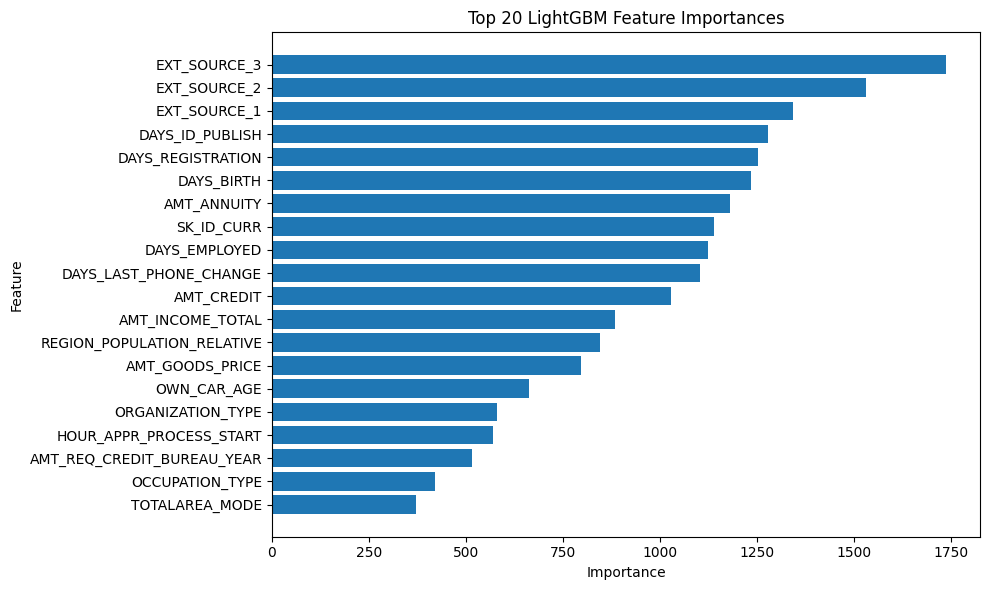

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'feature_importance_df' is already defined and contains the 'Feature' and 'Importance' columns

# Sort by importance and take the top 20 features
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot feature importance for the top 20 features
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 LightGBM Feature Importances')
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important feature at the top
plt.tight_layout()  # Adjust the layout
plt.show()


In [ ]:
top_features['Feature'].to_list()

['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'DAYS_ID_PUBLISH',
 'DAYS_REGISTRATION',
 'DAYS_BIRTH',
 'AMT_ANNUITY',
 'SK_ID_CURR',
 'DAYS_EMPLOYED',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_CREDIT',
 'AMT_INCOME_TOTAL',
 'REGION_POPULATION_RELATIVE',
 'AMT_GOODS_PRICE',
 'OWN_CAR_AGE',
 'ORGANIZATION_TYPE',
 'HOUR_APPR_PROCESS_START',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'OCCUPATION_TYPE',
 'TOTALAREA_MODE']

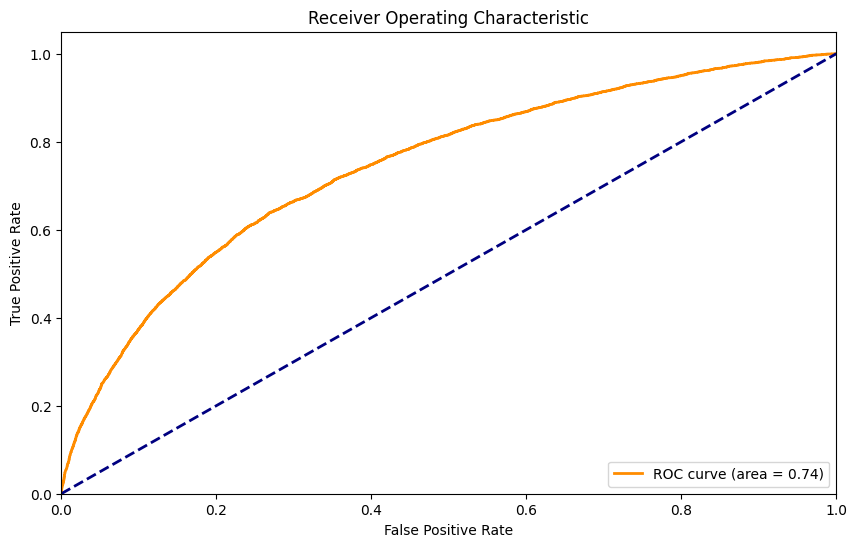

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test are the true labels and y_pred_proba are the predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming y_test are the true labels and y_pred_proba are the predicted probabilities
# To calculate the metrics, you need the predicted classes, which you can obtain by thresholding the predicted probabilities
threshold = 0.5  # This is the typical threshold, but you can adjust it based on your needs
y_pred_class = (y_pred_proba >= threshold).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
conf_matrix = confusion_matrix(y_test, y_pred_class)

# Print metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print('Confusion Matrix:')
print(conf_matrix)


Accuracy: 0.92
Precision: 0.48
Recall: 0.02
F1 Score: 0.05
Confusion Matrix:
[[56014   135]
 [ 4878   124]]


In [ ]:
from sklearn.impute import SimpleImputer

# Handle NaN values for numerical columns by imputation
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
imputer = SimpleImputer(strategy='mean')
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

# Split the data
X = df.drop('TARGET', axis=1)
y = df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Predict test set results and evaluate the model
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]  # Probability estimates

print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Coefficients as feature importance
feature_importance = pd.DataFrame(data={
    'Feature': X.columns,
    'Importance': model.coef_[0]
}).sort_values(by='Importance', key=abs, ascending=False)  # Sorting by absolute value to show the strongest effects, both positive and negative


              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.38      0.01      0.02      7413

    accuracy                           0.92     92254
   macro avg       0.65      0.50      0.49     92254
weighted avg       0.88      0.92      0.88     92254

Confusion Matrix:
[[84735   106]
 [ 7347    66]]


# Logistic regression

Test Accuracy: 0.9192


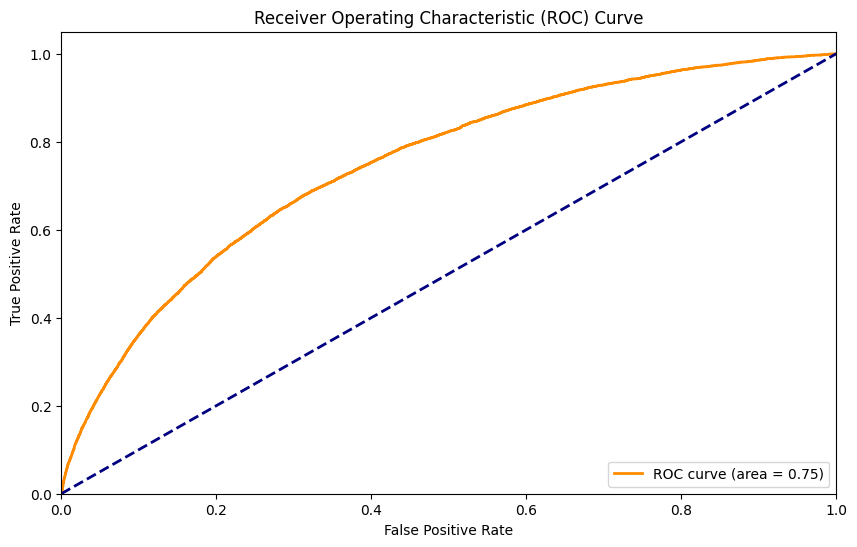

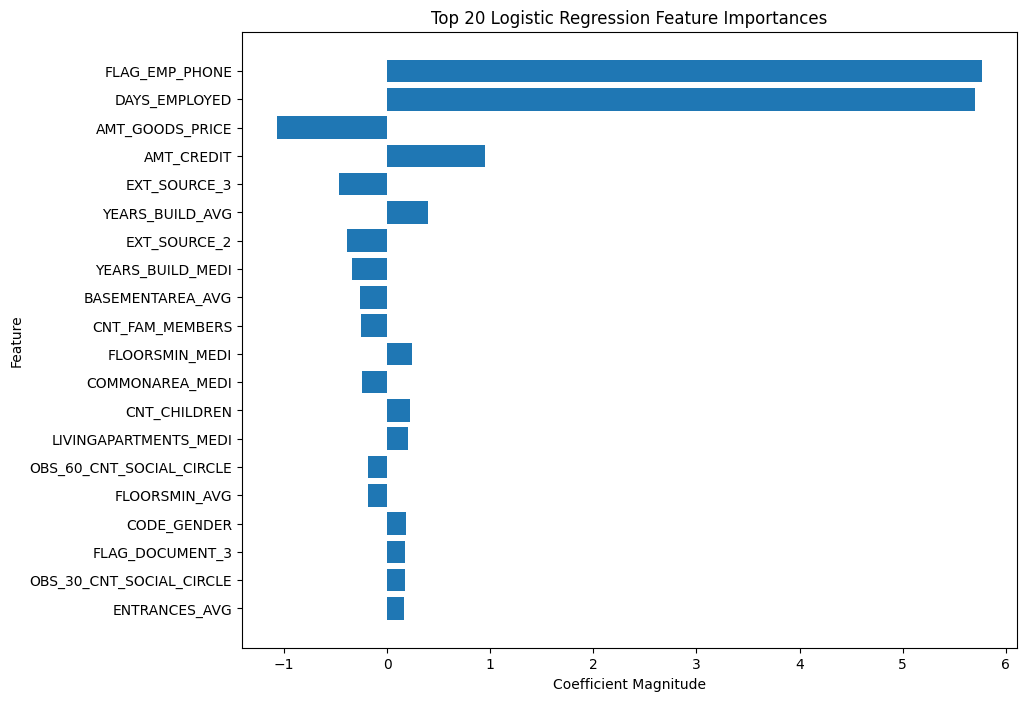

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc

# ... (previous steps remain the same)

# Fit the logistic regression model
model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]  # Get predicted probabilities for the positive class

# Test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Feature Importances
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.coef_[0]
}).sort_values(by='Importance', key=abs, ascending=False).head(20)  # Get top 20 features

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Top 20 Logistic Regression Feature Importances')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()


In [ ]:
feature_importance['Feature'].to_list()

['FLAG_EMP_PHONE',
 'DAYS_EMPLOYED',
 'AMT_GOODS_PRICE',
 'AMT_CREDIT',
 'EXT_SOURCE_3',
 'YEARS_BUILD_AVG',
 'EXT_SOURCE_2',
 'YEARS_BUILD_MEDI',
 'BASEMENTAREA_AVG',
 'CNT_FAM_MEMBERS',
 'FLOORSMIN_MEDI',
 'COMMONAREA_MEDI',
 'CNT_CHILDREN',
 'LIVINGAPARTMENTS_MEDI',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'FLOORSMIN_AVG',
 'CODE_GENDER',
 'FLAG_DOCUMENT_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'ENTRANCES_AVG']

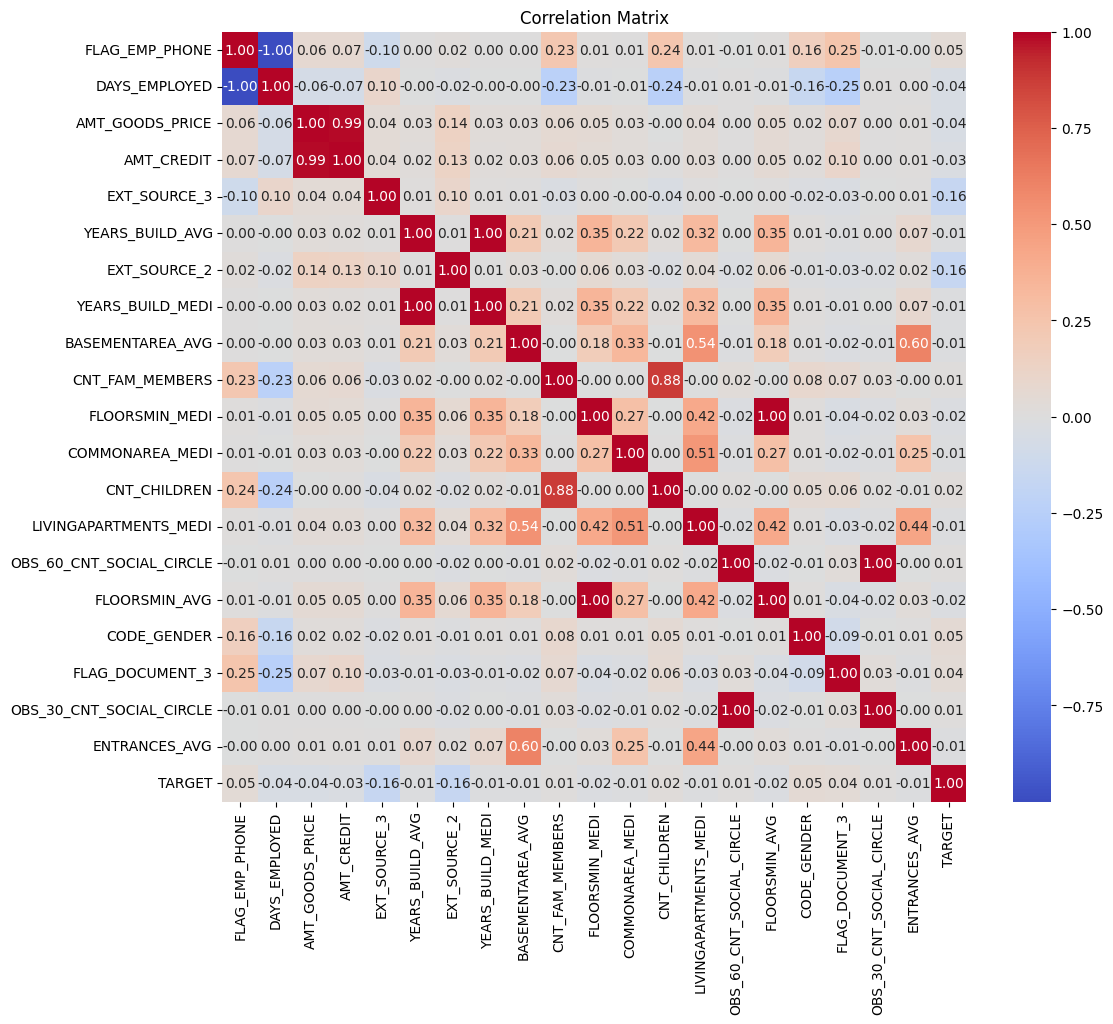

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Specify the columns to look at
columns_of_interest = [
    'FLAG_EMP_PHONE',
    'DAYS_EMPLOYED',
    'AMT_GOODS_PRICE',
    'AMT_CREDIT',
    'EXT_SOURCE_3',
    'YEARS_BUILD_AVG',
    'EXT_SOURCE_2',
    'YEARS_BUILD_MEDI',
    'BASEMENTAREA_AVG',
    'CNT_FAM_MEMBERS',
    'FLOORSMIN_MEDI',
    'COMMONAREA_MEDI',
    'CNT_CHILDREN',
    'LIVINGAPARTMENTS_MEDI',
    'OBS_60_CNT_SOCIAL_CIRCLE',
    'FLOORSMIN_AVG',
    'CODE_GENDER',  # Assuming you've already encoded this, if not, you'll need to encode it
    'FLAG_DOCUMENT_3',
    'OBS_30_CNT_SOCIAL_CIRCLE',
    'ENTRANCES_AVG',
    'TARGET'  # Include the target variable
]

# Select only the columns of interest from the DataFrame
df_selected = df[columns_of_interest]

# If 'CODE_GENDER' is categorical (e.g., 'M' and 'F'), encode it as numeric
# You can use LabelEncoder or map it directly if it's binary
if df_selected['CODE_GENDER'].dtype == 'object':
    df_selected['CODE_GENDER'] = df_selected['CODE_GENDER'].map({'M': 1, 'F': 0})

# Calculate the correlation matrix
corr_matrix = df_selected.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


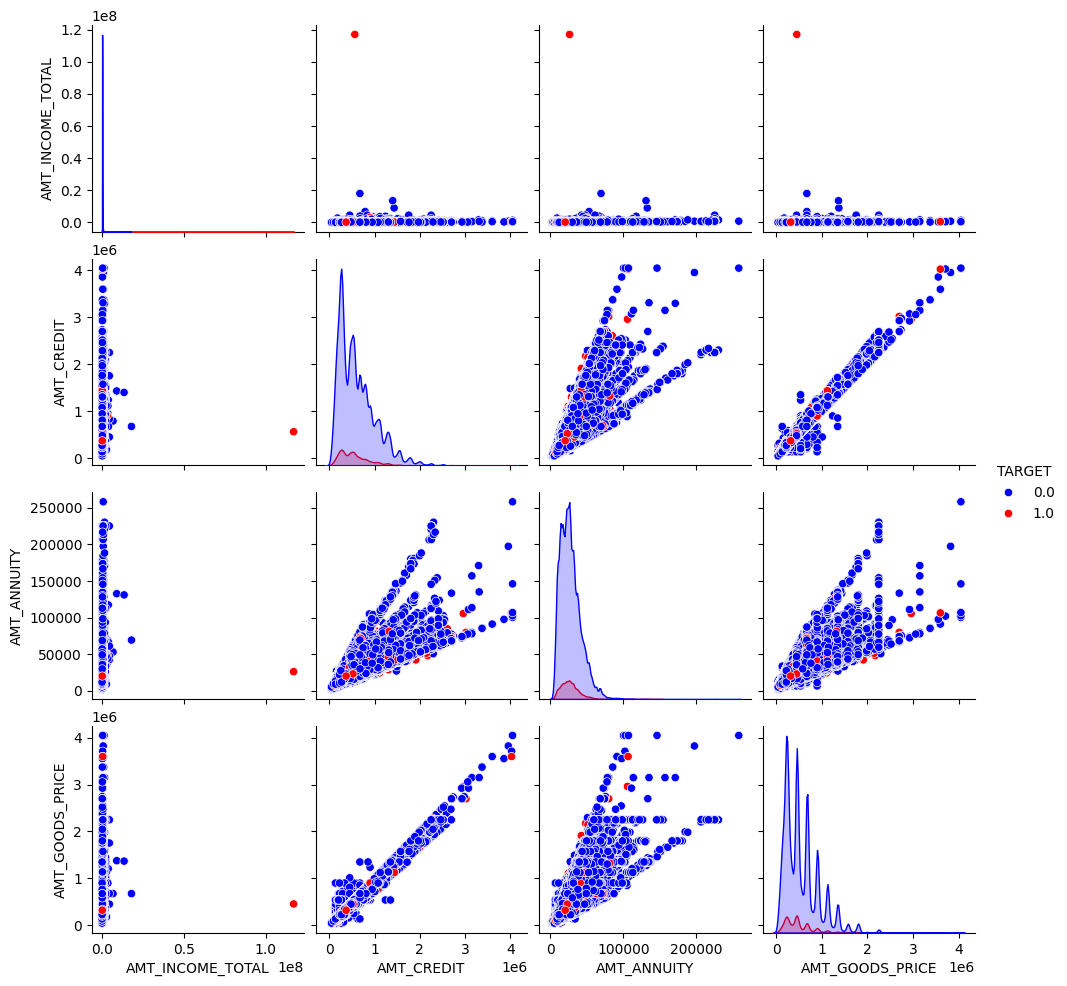

In [ ]:
amt = df[[ 'AMT_INCOME_TOTAL','AMT_CREDIT',
                         'AMT_ANNUITY', 'AMT_GOODS_PRICE',"TARGET"]]
amt = amt[(amt["AMT_GOODS_PRICE"].notnull()) & (amt["AMT_ANNUITY"].notnull())]
sns.pairplot(amt,hue="TARGET",palette=["b","r"])
plt.show()